# Python Exercise #3: Monte Carlo Simulation, <br>Geometric Brownian Motion, Efficient Portfolio

In [1]:
import math as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.stats as scs
import statsmodels.api as sm

%matplotlib inline

##### The Simplest Case (Two Assets) of the Markowitz Efficient Portfolio

In [2]:
ret = [0.1400, 0.0800]
sd = [0.2000, 0.1500]

In [3]:
columns = ['return', 'sigma']
index = ['XOM', 'PNRA']

df = pd.DataFrame(columns=columns, index=index)
df['return'] = ret
df['sigma'] = sd

df

,return,sigma
XOM,0.14,0.20
PNRA,0.08,0.15


###### Code snippet explination:
The following code specifies that we are working with a two asset portfolio,<br>
and then randomly assigns the weights those assets occupy within our portfolio.

The *weights /=* portion ensures that our weights equal to 1.

In [4]:
noa=2
weights = np.random.random(noa)
weights /= np.sum(weights)
print(weights); print(noa)

[0.623541 0.376459]
2


In [5]:
returns = df['return']
weights = np.array(weights)

port_return = np.sum(weights * ret)
port_return

0.11741246000468472

In [6]:
print(df['return'])
print(df['sigma'])

XOM     0.14
PNRA    0.08
Name: return, dtype: float64
XOM     0.20
PNRA    0.15
Name: sigma, dtype: float64


In [7]:
print(df.loc['XOM'])
print(df.loc['PNRA'])

return    0.14
sigma     0.20
Name: XOM, dtype: float64
return    0.08
sigma     0.15
Name: PNRA, dtype: float64


In [8]:
print(df[:])
print(df.loc['XOM']['sigma'])
print(df.loc['PNRA']['sigma'])

      return  sigma
XOM     0.14   0.20
PNRA    0.08   0.15
0.2
0.15


In [9]:
type(weights)

numpy.ndarray

In [10]:
weights[0]

0.6235410000780788

In [11]:
weights[1]

0.3764589999219212

In [12]:
corr = 0.300000

In [13]:
sigma_i = df['sigma'].iloc[0]
sigma_j = df['sigma'].iloc[1]

cov_12 = corr * sigma_i * sigma_j

variance_ij = ((weights[0]**2 * sigma_i**2) + (weights[1]**2 * sigma_j**2) +
               (2 * weights[0] * weights[1] * cov_12))
std_ij = np.sqrt(variance_ij)
portfolio_estimation = (f"######### Portfolio Estimations Assuming {corr:.3f}"
                        " Correlation Coefficient #########\n\n"
                        f"Variance: {variance_ij:.3f}\nStDev: "
                        f"{std_ij:.3f}")
print(portfolio_estimation)

######### Portfolio Estimations Assuming 0.300 Correlation Coefficient #########

Variance: 0.023
StDev: 0.152


#### Task 2: Monte Carlo Simulation

##### Gather data and format

In [14]:
ge_data = yf.download('GE', period='5y').resample('ME').mean()

C:\Users\Brady\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [15]:
monthly_returns = ge_data['Adj Close'].pct_change().dropna()
log_returns = np.log(1 + monthly_returns)
log_returns.rename('Log Returns', inplace=True).head()

Date
2019-03-31   -0.007387
2019-04-30   -0.047105
2019-05-31    0.044720
2019-06-30    0.025334
2019-07-31    0.017537
Freq: ME, Name: Log Returns, dtype: float64

##### Step 3: Calculate some statistics

In [16]:
log_mean = log_returns.mean()
log_std = log_returns.std()

annual_average = monthly_returns.mean() * 12
annual_std = monthly_returns.std() * np.sqrt(12)
print(f"Log Mean: {log_mean:.3f}\nLog Std: {log_std:.3f}")

Log Mean: 0.013
Log Std: 0.105


##### Step 4

In [17]:
np.random.seed(100)

In [18]:
I = 100000
M = 50
T = 1.0
dt = T / M
S0 = ge_data['Adj Close'].iloc[-1]

S = np.zeros((M + 1, I))
S[0] = S0

for t in range(1, M + 1):
    S[t] = S[t -1] * np.exp((annual_average - 0.5 * annual_std ** 2) * dt + 
                            annual_std * np.sqrt(dt) *
                            np.random.standard_normal(I))
    
print(S)

[[138.03000069 138.03000069 138.03000069 ... 138.03000069 138.03000069
  138.03000069]
 [126.66034479 140.91918289 146.86301169 ... 125.26639611 142.34114793
  142.17628198]
 [132.90386506 148.23333973 145.34255863 ... 131.22426314 137.61328602
  148.77562167]
 ...
 [131.16045619 180.03168113 140.70794985 ... 236.78922229 266.91075406
  124.51204355]
 [120.60206429 186.20451539 144.0798645  ... 255.09310961 281.46580138
  136.14163392]
 [131.08379069 188.07733299 136.61276321 ... 269.7169528  287.36344935
  133.40033778]]


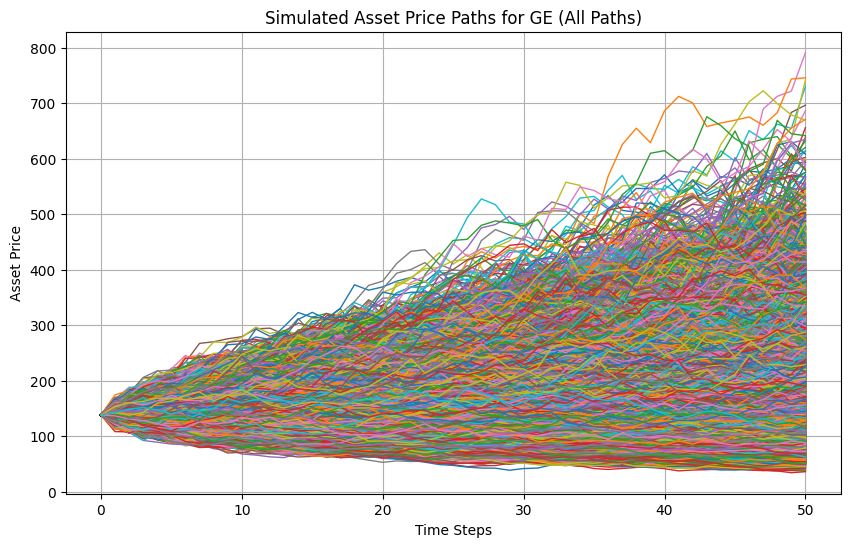

In [19]:
# num_simulations = S.shape[1]
# colors = plt.cm.viridis(np.linspace(0, 1, num_simulations))

plt.figure(figsize=(10, 6))
plt.plot(S, lw=1)
# for i in range(num_simulations):
#     plt.plot(S[:, i], color=colors[i], lw=1, alpha=0.8)
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.title('Simulated Asset Price Paths for GE (All Paths)')
plt.grid(True)
plt.show()

In [20]:
s_mean = np.mean(S)
s_med = np.median(S)
print(f"Mean: {s_mean:.3f}\nMedian: {s_med:.3f}")

Mean: 154.928
Median: 146.084


(array([1.78941350e-04, 1.19294233e-04, 4.17529816e-04, 7.15765398e-04,
        1.37188368e-03, 2.14729619e-03, 3.10165006e-03, 6.62082993e-03,
        1.09750694e-02, 1.44942493e-02, 2.42167293e-02, 3.62654468e-02,
        5.20122856e-02, 7.10993629e-02, 9.94317432e-02, 1.19711763e-01,
        1.59496390e-01, 1.97730191e-01, 2.39841055e-01, 2.68292730e-01,
        3.11179007e-01, 3.46430453e-01, 3.80190721e-01, 3.89078141e-01,
        3.90271083e-01, 3.91106143e-01, 3.77625895e-01, 3.53647754e-01,
        3.25196079e-01, 2.84337804e-01, 2.44254942e-01, 2.04828198e-01,
        1.67608397e-01, 1.32476246e-01, 1.02473746e-01, 7.64676034e-02,
        5.76787617e-02, 4.07389806e-02, 2.79744976e-02, 1.94449600e-02,
        1.38977781e-02, 7.51553668e-03, 4.77176932e-03, 3.28059141e-03,
        2.08764908e-03, 5.36824049e-04, 5.36824049e-04, 4.17529816e-04,
        2.38588466e-04, 1.78941350e-04]),
 array([-4.13434368, -3.96669098, -3.79903828, -3.63138559, -3.46373289,
        -3.29608019, 

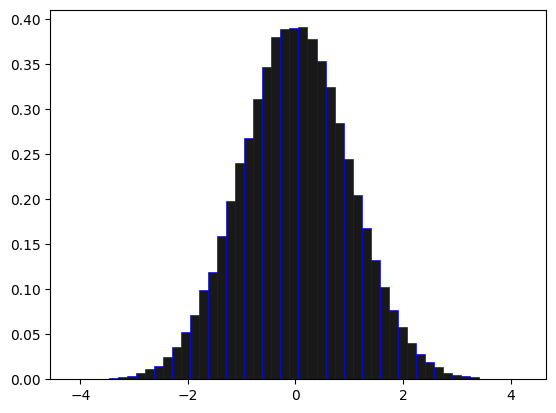

In [21]:
plt.hist(np.random.standard_normal(I), bins=50, alpha=0.9, color='black', density=True, edgecolor='blue', linewidth=0.5)

In [22]:
def normality_tests(arr):
    ''' Tests for normality distribution of given data set.

    Parameters
    ==========
    array: ndarray
        object to generate statistics on
    '''
    print('Skew of data set  %14.3f' % scs.skew(arr))
    print('Skew test p-value %14.3f' % scs.skewtest(arr)[1])
    print('Kurt of data set  %14.3f' % scs.kurtosis(arr))
    print('Kurt test p-value %14.3f' % scs.kurtosistest(arr)[1])
    print('Norm test p-value %14.3f' % scs.normaltest(arr)[1])

In [23]:
def print_statistics(array):
    ''' Prints selected statistics.

    Parameters
    ==========
    array: ndarray
        object to generate statistics on
    '''
    sta = scs.describe(array)
    print('%14s %15s' % ('statistic', 'value'))
    print(30 * '-')
    print('%14s %15.5f' % ('size', sta[0]))
    print('%14s %15.5f' % ('min', sta[1][0]))
    print('%14s %15.5f' % ('max', sta[1][1]))
    print('%14s %15.5f' % ('mean', sta[2]))
    print('%14s %15.5f' % ('annual mean', sta[2]*252))
    print('%14s %15.5f' % ('std', np.sqrt(sta[3])))
    print('%14s %15.5f' % ('annual std', np.sqrt(sta[3]*np.sqrt(252))))
    print('%14s %15.5f' % ('skew', sta[4]))
    print('%14s %15.5f' % ('kurtosis', sta[5]))


In [24]:
normality_tests(np.random.standard_normal(I))

Skew of data set           0.005
Skew test p-value          0.540
Kurt of data set          -0.004
Kurt test p-value          0.784
Norm test p-value          0.798


In [25]:
print_statistics(np.random.standard_normal(I))

     statistic           value
------------------------------
          size    100000.00000
           min        -4.42055
           max         4.00186
          mean        -0.00241
   annual mean        -0.60625
           std         0.99635
    annual std         3.96973
          skew         0.01296
      kurtosis        -0.02028


### Task 3: Python 101 Exercise

##### Exercise 1.1

In [26]:
ask = input("What is your age? (Whole Number Please) ")
while not ask.isdigit():
    ask = input("I'm sorry, that is non-numeric. Please try again. ")
print(f"You are {ask} years old.")

You are 31 years old.


##### Exercise 1.2

In [27]:
income = input("What is your annual income? (Whole Number Please) ")
while not income.isdigit():
    income = input("I'm sorry, that is not a whole number. Please try again.")
if int(income) > 120000:
    print("Sorry, you are not eligible for a $1,2000 stimulus payment.")
else:
    print("You are eligible for a $1,200 stimulus payment.")

You are eligible for a $1,200 stimulus payment.


##### Exercise 1.3

In [28]:
mealletters2 = []
meals = ['eggs', 'bacon', 'toast', 'burger', 'kale', 'beer', 'apple pie', 'coffee']
for meal in meals:
    mealletters2.append(meal[-1])

print(mealletters2)

mealletters2 = []
for i in range(0, len(meals)):
    mealletters2.append(meals[i][-1])
print(mealletters2)

mealletters2 = [meal[-1] for meal in meals]
print(mealletters2)


['s', 'n', 't', 'r', 'e', 'r', 'e', 'e']
['s', 'n', 't', 'r', 'e', 'r', 'e', 'e']
['s', 'n', 't', 'r', 'e', 'r', 'e', 'e']


##### Exercise 1.4

In [29]:
ages = {
    'John': 39,
    'Jane': 42,
    'Dan': 33,
    'Jen': 18,
}
names = []
agelist = []
for name, age in ages.items():
    names.append(name)
    agelist.append(age)

print(f"Names: {names}")
print(f"Ages: {agelist}")

Names: ['John', 'Jane', 'Dan', 'Jen']
Ages: [39, 42, 33, 18]


##### Exercise 1.5

In [30]:
def prices(houseprices):
    for key, value in houseprices.items():
        print(f"{key} is ${value:,.2f} dollars.")

In [31]:
houseprices = {'house1': 324411, 'house2': 112455, 'house3':653000}

prices(houseprices)

house1 is $324,411.00 dollars.
house2 is $112,455.00 dollars.
house3 is $653,000.00 dollars.
